In [209]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from plotnine import (
    ggplot, geom_point, geom_jitter, geom_line, geom_smooth, geom_ribbon, geom_rect, geom_boxplot,
    aes, facet_wrap, theme_bw, theme_void, theme_matplotlib, theme_linedraw, theme_minimal, theme_seaborn,
    theme, ylim, ggtitle, scale_color_brewer, scale_fill_brewer, scale_color_manual, scale_fill_manual,
    scale_x_continuous, scale_y_continuous
)
from tqdm.notebook import tqdm

In [96]:
import sys
sys.path.insert(0, '../../')
import taxus as tx
tx.__version__

'0.0.4alpha'

In [97]:
df = pd.read_csv('./fission.tsv', sep='\t')
norm_df, size_factors = tx.deseq_normalization(df, return_size_factors=True)
covariates = pd.DataFrame([c.split('_') for c in df.columns], columns=['genotype', 'time', 'rep'], index=df.columns)
covariates['time'] = covariates['time'].astype(np.int32)
covariates['genotype'] = [1 if c == 'mut' else 0 for c in covariates['genotype']]

In [98]:
size_factors

wt_0_r1       1.555841
wt_0_r2       0.723810
wt_0_r3       1.201452
wt_15_r1      1.207873
wt_15_r2      0.669186
wt_15_r3      0.490442
wt_30_r1      1.229228
wt_30_r2      0.659339
wt_30_r3      0.822324
wt_60_r1      0.509638
wt_60_r2      1.705746
wt_60_r3      1.085750
wt_120_r1     1.154090
wt_120_r2     0.828604
wt_120_r3     0.759045
wt_180_r1     1.089921
wt_180_r2     1.205657
wt_180_r3     0.794202
mut_0_r1      0.778088
mut_0_r2      1.296434
mut_0_r3      1.776386
mut_15_r1     0.650107
mut_15_r2     0.909533
mut_15_r3     0.775418
mut_30_r1     1.252766
mut_30_r2     0.933799
mut_30_r3     1.162014
mut_60_r1     1.402704
mut_60_r2     1.148666
mut_60_r3     1.406477
mut_120_r1    1.216822
mut_120_r2    1.070046
mut_120_r3    1.246027
mut_180_r1    1.004215
mut_180_r2    0.890764
mut_180_r3    0.731695
dtype: float64

In [99]:
covariates[['genotype', 'time']]

,genotype,time
wt_0_r1,0,0
wt_0_r2,0,0
wt_0_r3,0,0
wt_15_r1,0,15
wt_15_r2,0,15
wt_15_r3,0,15
wt_30_r1,0,30
wt_30_r2,0,30
wt_30_r3,0,30
wt_60_r1,0,60


In [100]:
df.T[['SPBC2F12.09c']]

,SPBC2F12.09c
wt_0_r1,4
wt_0_r2,1
wt_0_r3,4
wt_15_r1,282
wt_15_r2,170
wt_15_r3,123
wt_30_r1,1081
wt_30_r2,732
wt_30_r3,870
wt_60_r1,8


In [102]:
gene_id = 'SPAC1002.18'
gp = tx.GP('~ C(genotype) + C(time) + C(genotype):C(time)', covariates[['genotype', 'time']], 
      norm_df.T[[gene_id]], likelihood='nb', kernel='linear')
print(gp.variable_names)
gp.fit(n_steps=5000, hyper_lr=0.01, variational_lr=0.01)
gp.elbo

['C(genotype)[0]', 'C(genotype)[1]', 'C(time)[T.15]', 'C(time)[T.30]', 'C(time)[T.60]', 'C(time)[T.120]', 'C(time)[T.180]', 'C(genotype)[T.1]:C(time)[T.15]', 'C(genotype)[T.1]:C(time)[T.30]', 'C(genotype)[T.1]:C(time)[T.60]', 'C(genotype)[T.1]:C(time)[T.120]', 'C(genotype)[T.1]:C(time)[T.180]']


Fitting GP:  93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋          | 4644/5000 [00:15<00:01, 308.88it/s, loss=6.08]


tensor(-6.0797, grad_fn=<SubBackward0>)

In [105]:
dict(gp.named_hyperparameters())

{'likelihood.alpha': Parameter containing:
 tensor([0.0359], requires_grad=True),
 'mean_module.constant': Parameter containing:
 tensor([5.8025], requires_grad=True),
 'covar_module.raw_outputscale': Parameter containing:
 tensor(3.6312, requires_grad=True),
 'covar_module.base_kernel.raw_variance': Parameter containing:
 tensor([[-2.3796]], requires_grad=True)}

In [108]:
gp.covar_module.base_kernel.variance

tensor([[0.0885]], grad_fn=<SoftplusBackward0>)

In [9]:
gp = tx.GP('~ C(genotype) + C(time) + C(genotype):C(time)', covariates[['genotype', 'time']], 
      norm_df.T[[gene_id]], likelihood='nb', kernel='linear')
print(gp.variable_names)
gp.fit(n_steps=5000, hyper_lr=0.05, variational_lr=0.05)
gp.elbo

['C(genotype)[0]', 'C(genotype)[1]', 'C(time)[T.15]', 'C(time)[T.30]', 'C(time)[T.60]', 'C(time)[T.120]', 'C(time)[T.180]', 'C(genotype)[T.1]:C(time)[T.15]', 'C(genotype)[T.1]:C(time)[T.30]', 'C(genotype)[T.1]:C(time)[T.60]', 'C(genotype)[T.1]:C(time)[T.120]', 'C(genotype)[T.1]:C(time)[T.180]']


Fitting GP:   0%|                                                                                                                                                                                  | 0/5800 [00:00<?, ?it/s]


NanError: cholesky_cpu: 144 of 144 elements of the torch.Size([12, 12]) tensor are NaN.

In [10]:
gene_id = 'SPAC1002.18'
lr = [tx.LRT('~ genotype + time', '~ time', covariates[['genotype', 'time']], 
      norm_df.T[[gene_id]], kernel='rbf', likelihood='nb').fit(combine_terms=True) for _ in range(10)]
sorted(lr)

[-0.11823892593383789,
 1.1049704551696777,
 1.5102763175964355,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf,
 inf]

In [33]:
def lrt(gene_id):
    with warnings.catch_warnings(record=True) as w:
        lr = [tx.LRT('~ genotype + time', '~ time', covariates[['genotype', 'time']], 
              norm_df.T[[gene_id]], kernel='rbf', likelihood='nb').fit(combine_terms=True) for _ in range(10)]
    return sorted(lr)[0]
nb_rbf_lrs = Parallel(n_jobs=8)(delayed(lrt)(gene_id) for gene_id in tqdm(norm_df.index))
nb_rbf_lrs_df = pd.DataFrame(nb_rbf_lrs, index=norm_df.index)
#nb_rbf_lrs_df.to_csv('./nb_rbf_lrs.tsv', sep='\t')

  0%|          | 0/7039 [00:00<?, ?it/s]

In [11]:
from joblib import Parallel, delayed
import warnings

def lrt(gene_id):
    with warnings.catch_warnings(record=True) as w:
        lr = [tx.LRT('~ genotype + time', '~ time', covariates[['genotype', 'time']], 
              norm_df.T[[gene_id]], kernel='rbf', likelihood='poisson').fit(combine_terms=True) for _ in range(10)]
    return sorted(lr)[0]
poisson_lrs = Parallel(n_jobs=8)(delayed(lrt)(gene_id) for gene_id in tqdm(norm_df.index))

  0%|          | 0/7039 [00:00<?, ?it/s]

In [24]:
poisson_lrs_df = pd.DataFrame(poisson_lrs, index=norm_df.index)
#poisson_lrs_df.to_csv('./poisson_lrt.tsv', sep='\t')
poisson_lrs_df[0]

SPAC212.11        -3.780341e-01
SPAC212.09c       -1.453565e+00
SPNCRNA.70        -1.192093e-07
SPAC212.12         0.000000e+00
SPAC212.04c       -2.872204e+00
                       ...     
SPMITTRNATYR.01   -1.112583e+00
SPMITTRNAILE.02   -2.428604e+00
SPMIT.10           9.655151e-01
SPMITTRNAGLU.01    6.047363e-01
SPMIT.11           6.582642e-01
Name: 0, Length: 7039, dtype: float64

In [77]:
deseq2_df = pd.read_csv('./deseq2_results.tsv', sep='\t')
deseq2_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SPAC212.11,8.552427,0.043102,0.534477,9.757149,1.786267e-03,7.892267e-02
SPAC212.09c,50.762750,0.655948,0.268299,3.181313,7.448488e-02,5.271287e-01
SPNCRNA.70,0.032659,0.305784,5.134285,0.025813,8.723579e-01,9.904500e-01
SPAC212.12,0.564695,-0.171896,2.006975,0.017213,8.956174e-01,9.909630e-01
SPAC212.04c,38.316893,0.303933,0.260991,71.645054,2.576070e-17,5.804745e-14
...,...,...,...,...,...,...
SPMITTRNATYR.01,1339.088992,0.145033,0.239743,2.727990,9.860328e-02,5.811318e-01
SPMITTRNAILE.02,795.499863,-0.126274,0.186129,7.968836,4.758953e-03,1.434046e-01
SPMIT.10,12861.531361,0.036999,0.132111,1.073895,3.000674e-01,8.115504e-01
SPMITTRNAGLU.01,12160.507902,0.520018,0.234061,2.757580,9.679458e-02,5.779268e-01


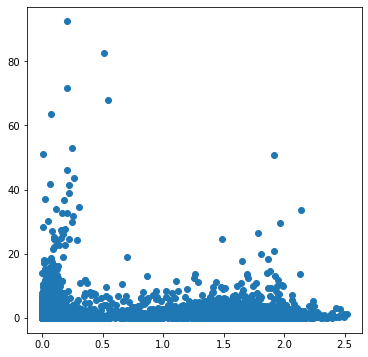

In [79]:
fig,ax = plt.subplots(1, figsize=(6,6))
ax.scatter(np.abs(nb_rbf_lrs_df[0]), deseq2_df['stat'])


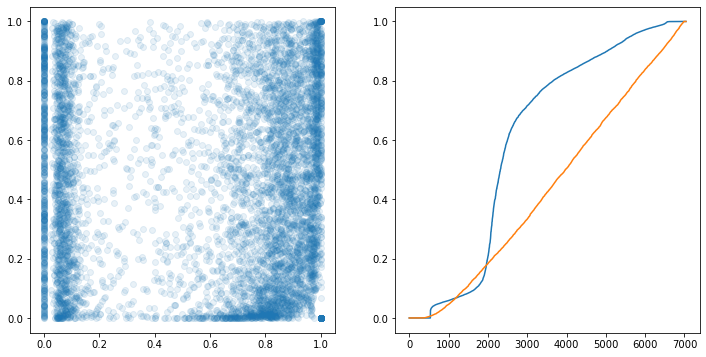

In [83]:
fig,[ax1,ax2] = plt.subplots(ncols=2, figsize=(12,6))
lrs_df = nb_rbf_lrs_df
taxus_pvals = np.nan_to_num(1 - chi2.cdf(2 * np.abs(lrs_df[0]), df=1))
deseq_pvals = np.nan_to_num(deseq2_df.loc[lrs_df.index]['pvalue'])
ax1.scatter(taxus_pvals, deseq_pvals, alpha=.1)
#ax1.set_yscale('log')
#ax1.set_xscale('log')
ax2.plot(sorted(taxus_pvals))
ax2.plot(sorted(deseq_pvals))


/var/folders/8s/ymk92z8x4cb3wb1qbzb0k5v00000gn/T/ipykernel_60954/2265838748.py:6: RuntimeWarning: overflow encountered in multiply


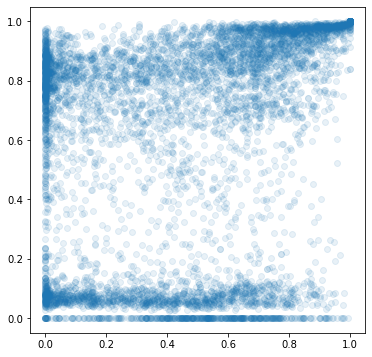

In [87]:
fig,ax = plt.subplots(1, figsize=(6,6))
poisson_lr = np.nan_to_num(poisson_lrs_df[0])
poisson_pval = 1 - chi2.cdf(2 * np.abs(poisson_lr), df=1)

nb_lr = np.nan_to_num(nb_rbf_lrs_df[0])
nb_pval = 1 - chi2.cdf(2 * np.abs(nb_lr), df=1)

ax.scatter(poisson_pval, nb_pval, alpha=.1)

In [86]:
nb_pval.shape, poisson_pval.shape

((7039,), (7039,))

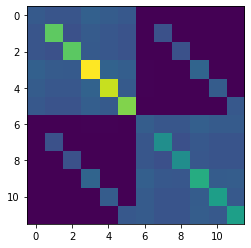

In [16]:
A = dict(gp.named_variational_parameters())['variational_strategy._variational_distribution.natural_tril_mat'].detach().numpy()
plt.imshow(np.dot(A, A.T))

In [179]:
gene_id = 'SPAC11D3.01c'

full_models = [tx.GP('~ genotype + time', covariates[['genotype', 'time']], norm_df.T[[gene_id]], likelihood='nb', kernel='rbf') for _ in range(10)]
reduced_models = [tx.GP('~ time', covariates[['genotype', 'time']], norm_df.T[[gene_id]], likelihood='nb', kernel='rbf') for _ in range(10)]

elbo_full = [(model, model.fit(n_steps=10000, tol=1e-4)) for model in full_models]
elbo_reduced = [(model, model.fit(n_steps=10000, tol=1e-4)) for model in reduced_models]

Fitting GP:   4%|██████                                                                                                                                                     | 392/10000 [00:01<00:26, 366.43it/s, loss=6.39]


In [180]:
full_gp = sorted(elbo_full, key=lambda m: m[1] or np.inf)[0][0]

In [181]:
reduced_gp = sorted(elbo_reduced, key=lambda m: m[1] or np.inf)[0][0]

In [182]:
full_gp.likelihood(full_gp(full_gp.train_x)).log_prob(full_gp.train_y).mean(dim=0).sum().item()

-213.8624725341797

In [183]:
dict(full_gp.likelihood.named_parameters())

{'alpha': Parameter containing:
 tensor([0.1247], requires_grad=True)}

In [184]:
reduced_gp.likelihood(reduced_gp(reduced_gp.train_x)).log_prob(reduced_gp.train_y).mean(dim=0).sum().item()

-225.1414031982422

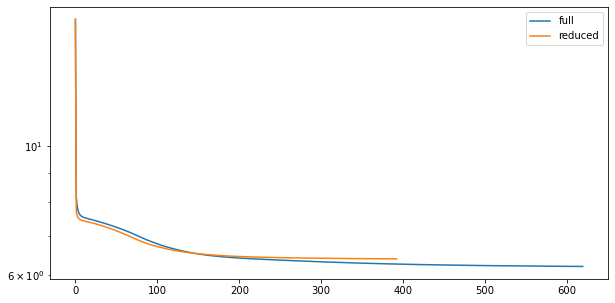

In [185]:
fig,ax = plt.subplots(1, figsize=(10,5))
ax.plot(full_gp.losses_, label='full')
ax.plot(reduced_gp.losses_, label='reduced')
ax.set_yscale('log')
ax.legend()

In [207]:
time = np.tile(np.arange(0, 189, 5), 2)
genotype = np.repeat([0,1], len(time)/2)
x_pred = pd.DataFrame(dict(time=time, genotype=genotype))
percentiles = full_gp.predict(x_pred, percentiles=[5, 16, 50, 84, 95])
percentiles

,p5,p16,p50,p84,p95,mean
0,62.0,84.0,129.0,193.0,248.00,138.957901
1,70.0,95.0,145.0,215.0,275.00,155.425705
2,80.0,107.0,163.0,239.0,301.00,173.111298
3,91.0,121.0,184.0,270.0,338.00,195.669998
4,104.0,140.0,210.0,303.0,380.05,221.764206
...,...,...,...,...,...,...
71,75.0,104.0,164.0,250.0,325.00,177.374893
72,73.0,101.0,159.0,241.0,315.00,171.880600
73,72.0,98.0,156.0,237.0,305.00,168.167496
74,68.0,95.0,153.0,234.0,304.00,165.492706


/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.


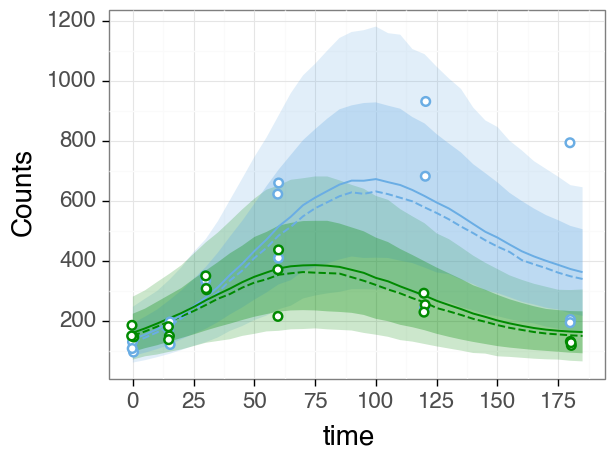

/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: ./gpcounts_reproduction.png
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet implementedfor lowess smoothings.
/Users/rensholmer/miniconda3/envs/jupyter/lib/python3.9/site-packages/plotnine/stats/smoothers.py:310: PlotnineWarning: Confidence intervals are not yet

In [229]:
colors = {0:'#6aade4', 1:'#008a00'}

train_df = pd.concat([full_gp.train_x_df, full_gp.train_y_df], axis=1)
train_df.columns = [*full_gp.variable_names, 'Counts']
test_df = pd.concat([x_pred, percentiles], axis=1)
train_aes = dict(x='time', color='factor(genotype)')
test_aes =  dict(x='time', fill='factor(genotype)')
p = (
    ggplot(train_df, aes(y='Counts', **train_aes))
    #+ geom_ribbon(mapping=aes(**test_aes, ymin='p0.5', ymax='p99.5'), alpha=.15,
    #             data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(**test_aes, ymin='p5', ymax='p95'), alpha=.2,
                 data=test_df, inherit_aes=False)
    + geom_ribbon(mapping=aes(**test_aes, ymin='p16', ymax='p84'), alpha=.3,
                 data=test_df, inherit_aes=False)
    + geom_smooth(aes(**train_aes, y='p50'), method='lowess', span=.05, linetype='dashed', alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + geom_smooth(aes(**train_aes, y='mean'), method='lowess', span=.05, alpha=.7, size=.8,
                 data=test_df, inherit_aes=False)
    + geom_jitter(fill='white', size=2.5, stroke=1., width=.5)
    + theme_bw(base_size=20, base_family='Helvetica')
    + scale_color_manual(colors, guide=False)
    + scale_fill_manual(colors, guide=False)
    + scale_x_continuous(breaks=[0,25,50,75,100,125,150,175])
    + scale_y_continuous(breaks=[0, 200, 400, 600, 800, 1000, 1200])
)
print(p)
p.save('./gpcounts_reproduction.png')

In [94]:
plt.matshow(full_gp.variational_strategy.variational_distribution.covariance_matrix.detach().numpy())

NameError: name 'full_gp' is not defined

In [76]:
#original_lengthscale = full_gp.covar_module.base_kernel.lengthscale
full_gp.covar_module.base_kernel.lengthscale = torch.tensor([[5., 50.]])

RuntimeError: Kernel has no lengthscale.

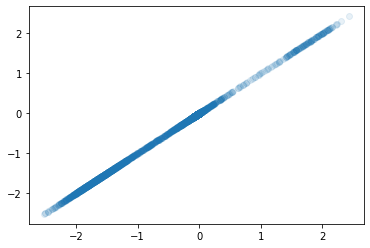

In [93]:
df1 = pd.read_csv('./nb_rbf_lrs.tsv', sep='\t', index_col=0)
df2 = pd.read_csv('./nb_rbf_lrs.tsv', sep='\t', index_col=0)
plt.scatter(df1, df2, alpha=.1)

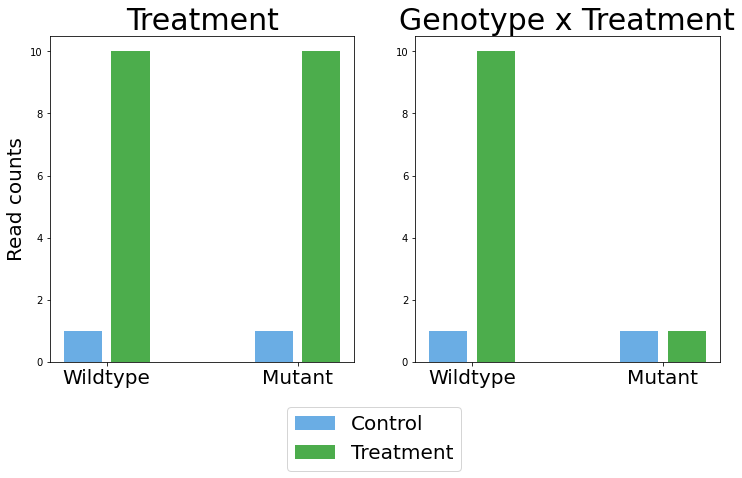

In [169]:
fig,[ax1,ax2] = plt.subplots(ncols=2, figsize=(12,6))
ax1.bar([0,4],[1,1], color='#6aade4', label='Control')
ax1.bar([1,5],[10,10], color='#008a00', alpha=.7, label='Treatment')
ax1.set_title('Treatment', fontsize=30)
ax1.set_ylabel('Read counts', fontsize=20)

ax2.bar([0,4], [1,1], color='#6aade4')
ax2.bar([1,5], [10,1], color='#008a00', alpha=.7)
ax2.set_title('Genotype x Treatment', fontsize=30)

for ax in [ax1,ax2]:
    ax.set_xticks([.5, 4.5])
    ax.set_xticklabels(['Wildtype','Mutant'], fontsize=20)

fig.legend(loc=8, fontsize=20, bbox_to_anchor=(.5, -.15))
fig.savefig('hypothesis_testing_glm.pdf')